In [1]:
import os
import numpy as np
import keras
from keras.engine import  Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau

In [2]:
from keras import backend as k
k.clear_session()

In [3]:
print(keras.__version__)

2.4.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

In [5]:
# data are in dataset folder in zipped format
!ls "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/"

fer2013.csv  PrivateTest.zip  PublicTest.zip  Training.zip


In [6]:
!ls 

drive  sample_data


In [7]:
# This creates a temporary folder in drive root folder, so it will have to be reloaded again when required after terminating the session
# Permanent data are stored in dataset in zipped format
# This copies the zipped file and store in root of google drive temporarily
! rm -rf Training; mkdir Training
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/Training.zip" -d Training

! rm -rf Validation; mkdir Validation
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PublicTest.zip" -d Validation

! rm -rf Test; mkdir Test
! unzip -q "drive/My Drive/ENGR635-Deep Learning System Design Project/Dataset/fer2013/PrivateTest.zip" -d Test

In [8]:
!ls

drive  sample_data  Test  Training  Validation


In [9]:
!ls -l Training/

total 808
drwxr-xr-x 2 root root 122880 Oct 11 05:04 Angry
drwxr-xr-x 2 root root  16384 Oct 11 05:04 Disgust
drwxr-xr-x 2 root root 122880 Oct 11 05:04 Fear
drwxr-xr-x 2 root root 217088 Oct 11 05:04 Happy
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Neutral
drwxr-xr-x 2 root root 135168 Oct 11 05:04 Sad
drwxr-xr-x 2 root root  77824 Oct 11 05:04 Surprise


In [10]:
# Counting the images in each training data categories
%%bash
root='Training/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830
Surprise: 3171


In [11]:
%%bash
root='Validation/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 467
Disgust: 56
Fear: 496
Happy: 895
Neutral: 607
Sad: 653
Surprise: 415


In [12]:
%%bash
root='Test/'
IFS=$(echo -en "\n\b")
(for dir in $(ls -1 "$root")
    do printf "$dir: " && ls -i "$root$dir" | wc -l
 done)

Angry: 491
Disgust: 55
Fear: 528
Happy: 879
Neutral: 626
Sad: 594
Surprise: 416


In [13]:
train_dir = "Training/"
validation_dir = "Validation/"
test_dir = "Test/"

## All data are ready

In [14]:
# Setting image height and width
img_height = 224
img_width = 224

In [15]:
conv_base = InceptionV3(weights="imagenet",
                        include_top=False,
                        input_shape=(img_height, img_width, 3)
                        )

87916544/87910968 [==============================] - 0s 0us/step


In [16]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
print("Number of trainable weights before freezing the conv base:", len(conv_base.trainable_weights))
conv_base.trainable = False
print("Number of trainable weights after freezing the conv base:", len(conv_base.trainable_weights))

Number of trainable weights before freezing the conv base: 188
Number of trainable weights after freezing the conv base: 0


In [18]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [19]:
from keras.layers import GlobalAveragePooling2D
DROP_OUT_RATE = 0.5
last_layer = conv_base.output

x = GlobalAveragePooling2D(name='global_avg_pool_1')(last_layer)

x = Dropout(DROP_OUT_RATE)(x)
x = Dense(2048, activation='relu', name='fc1')(x)

out = Dense(7, activation='softmax', name='classifier')(x)

model = Model(conv_base.input, out)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
# Image Data Generator setup
train_datagen = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                   featurewise_std_normalization=False,
                                   rotation_range=90,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True
                                   )
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    shuffle = True,
    class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    class_mode = 'categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 50,
    class_mode = 'categorical'
)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [22]:
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}
{'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3, 'Neutral': 4, 'Sad': 5, 'Surprise': 6}


In [23]:
def class_weight_computer():
  """
    Training Data categories and number of samples in them
    Angry: 3995
    Disgust: 436
    Fear: 4097
    Happy: 7215
    Neutral: 4965
    Sad: 4830
    Surprise: 3171
  """
  samples_per_label = [3995, 436, 4097, 7215, 4965, 4830, 3171]
  total_samples = sum(samples_per_label)
  return dict([(i, total_samples/(7*j)) for (i,j) in enumerate(samples_per_label)]) # https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_class_weight.html
class_weight_computer()

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8260394187886635,
 5: 0.8491274770777877,
 6: 1.293372978330405}

In [24]:
class_weights = class_weight_computer()
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [25]:
EPOCHS = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch=28709//50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=3589//50,
    shuffle=True,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
574/574 [==============================] - 322s 561ms/step - loss: 1.9533 - accuracy: 0.2231 - val_loss: 1.7634 - val_accuracy: 0.3313
Epoch 2/10
574/574 [==============================] - 318s 554ms/step - loss: 1.8220 - accuracy: 0.2543 - val_loss: 1.7531 - val_accuracy: 0.3138
Epoch 3/10
574/574 [==============================] - 310s 540ms/step - loss: 1.8091 - accuracy: 0.2634 - val_loss: 1.6982 - val_accuracy: 0.3777
Epoch 4/10
574/574 [==============================] - 312s 543ms/step - loss: 1.7925 - accuracy: 0.2752 - val_loss: 1.6297 - val_accuracy: 0.3766
Epoch 5/10
574/574 [==============================] - 319s 555ms/step - loss: 1.7941 - accuracy: 0.2788 - val_loss: 1.8203 - val_accuracy: 0.2586
Epoch 6/10
574/574 [==============================] - 311s 543ms/step - loss: 1.7789 - accuracy: 0.2797 - val_loss: 1.6079 - val_accuracy: 0.3814
Epoch 7/10
574/574 [============================

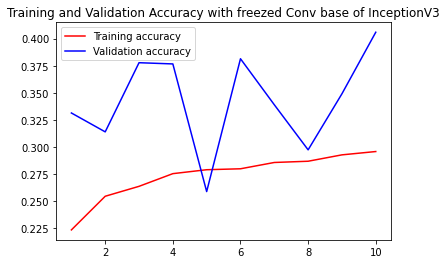

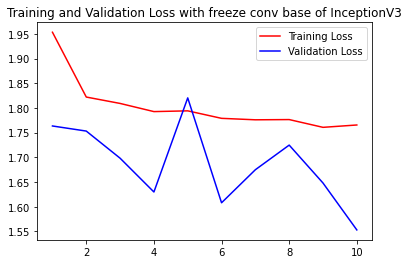

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label="Training accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation accuracy")
plt.title('Training and Validation Accuracy with freezed Conv base of InceptionV3')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss with freeze conv base of InceptionV3')
plt.legend()
plt.show()

In [27]:
print('\nEvaluate on Validation data')
results_validation = model.evaluate_generator(validation_generator, 3589//50 )
print('Validation loss, Validation Accuracy:', results_validation)


Evaluate on Validation data
Instructions for updating:
Please use Model.evaluate, which supports generators.
Validation loss, Validation Accuracy: [1.5535104274749756, 0.405633807182312]


In [28]:
print('\nEvaluate on test data')
results_test = model.evaluate_generator(test_generator, 3589//50)
print('test loss, test acc:', results_test)


Evaluate on test data
test loss, test acc: [1.5567048788070679, 0.406760573387146]


In [1]:
EPOCHS=10
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]

NameError: ignored

In [ ]:
print(epoch_str)
print(test_acc)

In [ ]:
# Saving the history contents
history_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/InceptionV3/history_InceptionV3"+epoch_str + test_acc + ".npy"
np.save(history_path)

In [ ]:
# Saving the model
model_path = "drive/My Drive/ENGR635-Deep Learning System Design Project/Models/InceptionV3/InceptionV3" + epoch_str + test_acc + '.h5'
model.save(model_path)

### Finetune